In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.stats as sps
from random import choices
import time
from numpy.random import RandomState
import pandas as pd
from scipy.stats import cauchy, gamma, norm, dirichlet, expon, uniform, invgauss, mode 
from scipy.stats import beta as beta_dist

In [2]:
def genParam(n, randomstate) :
    r = np.random.RandomState(seed=randomstate)
    
    alpha = r.exponential(1,(n,3))
    ksi = np.abs(r.standard_cauchy(2))
    beta = [r.dirichlet(alpha[0])]
    for i in range(1,n) :
      betai = [r.dirichlet(alpha[i])]
      beta = np.concatenate((beta,betai), axis=0)
    
    mu = [[beta[0][0]-beta[0][1], 2*(beta[0][0]+beta[0][1])-1]]
    for i in range(1,n) :
      mui = [[beta[i][0]-beta[i][1], 2*(beta[i][0]+beta[i][1])-1]]
      mu = np.concatenate((mu, mui),axis=0)
    sigma = r.wald(ksi[0], ksi[1],n)
    
    return(alpha, ksi, beta, mu, sigma)

In [3]:
def genX(n, T, mu, sigma) :
    A = np.eye(T, T+2) + mu[0][0]*np.eye(T, T+2,1) + mu[0][1]*np.eye(T, T+2,2)
    A = A@A.T
    X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
    for i in range(1,n) :
      A = np.eye(T, T+2) + mu[i][0]*np.eye(T, T+2,1) + mu[i][1]*np.eye(T, T+2,2)
      A = sigma[i]*A@A.T
      Xi = [np.random.multivariate_normal(np.zeros(T), A)]
      X = np.concatenate((X,Xi), axis=0)
    return(X)

Algorithme 1 : Gibbs-ABC

In [4]:
def prior(n, hyper):
    X_1 = beta_dist.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta_dist.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def distautcor(Z, X):
    min_length = min(len(Z), len(X))
    Z = Z[:min_length]
    X = X[:min_length]
    
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)

In [5]:
def ABCbas(X, N, T, mu, sigma):
    distances = []
    for i in range(N):
        simulated_X = genX(1, T, [mu], [sigma])  
        simulated_X = np.array(simulated_X) 
        distance = distautcor(X.flatten(), simulated_X.flatten())
        distances.append((distance, mu, sigma))
    min_distance_index = np.argmin([d[0] for d in distances])
    distance_values = np.array([d[0] for d in distances])
    return distances[min_distance_index][1], distances[min_distance_index][2]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Eviter la division par 0
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])

def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = expon.rvs(size=(L, 3))  
    dist = np.zeros(L)
    for i in range(L):
        U = prior(len(Q1), hyper[i]) 
        dist[i] = np.sum((statdir(U) - statdir(Q))**2)
    return hyper[np.argmin(dist)]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N, T):
    dist = np.zeros(N)
    w = np.arange(1, min(Dat.shape[0], 10))
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        simulated_data = genX(1, T, np.array([[parh1[j], parh2[j]]]), np.array([si[i]]))
        simulated_data = np.array(simulated_data)
        if j >= Dat.shape[1]:
            raise IndexError(f"Index {j} is out of bounds for axis 1 with size {Dat.shape[1]}")
        valid_w = w[w < Dat.shape[0]] 
        if len(valid_w) == 0:
            raise ValueError("No valid indices in w for accessing Dat.")
        dist[i] = np.abs(np.var(simulated_data.flatten()[valid_w]) - np.var(Dat[valid_w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    pri = np.abs(cauchy.rvs(size=(Q, 2)))
    for i in range(Q):
        h = pri[i]
        y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist)]

In [6]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()

    eps_estimate = float('inf')  
    facteur_decroissance = 0.99 

    results = {
        "Paramètres_mu": [],
        "Paramètres_sigma": [],
        "Hyperparamètres": [],
        "Hypersigma": [],
        "Histeps": [],  
        "Eps_final": None  
    }
    
    for iteration in range(Npts):
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break

        mu_updates = []
        sigma_updates = []
        dist_i = [] 

        for j in range(n):
            mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])
            mu[j] = mu_best
            sigma[j] = sigma_best
            mu_updates.append(mu_best)
            sigma_updates.append(sigma_best)
            simu_j = genX(1, T, [mu[j]], [sigma[j]])  
            # Calculer la distance en utilisant la variance
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
        
        # Mettre à jour eps_estimate avec la distance maximale de cette itération si elle est plus petite
        eps_iteration = max(dist_i)
        eps_estimate = min(eps_estimate, eps_iteration) * facteur_decroissance
        # Vérifier si l'estimation d'epsilon dépasse l'objectif après toutes les mises à jour
        if eps_estimate > objectifeps:
            print(f"L'objectif epsilon de {objectifeps} a été dépassé avec une estimation de {eps_estimate}. Arrêt du programme.")
            break  # Sortir de la boucle principale si l'objectif epsilon est dépassé

        results["Histeps"].append(eps_estimate)  
        results["Eps_final"] = eps_estimate
        results["Paramètres_mu"].append(mu_updates)
        results["Paramètres_sigma"].append(sigma_updates)
        
        # Mettre à jour les hyperparamètres à l'aide d'ABChaut 
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        # Mettre à jour le sigma à l'aide d'ABCsigm pour chaque trajectoire
        for j in range(n):
            sigma_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T)
            sigma[j] = sigma_j
        
        # Mettre à jour l'hypersigma à l'aide d'ABCsigmhaut
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)

    return results

In [7]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()

    eps_estimate = float('inf')  
    facteur_decroissance = 0.99 

    results = {
        "Paramètres_sigma": [],
        "Hyperparamètres": [],
        "Hypersigma": [],
        "Histeps": [],  
        "Eps_final": None  
    }
    
    for iteration in range(Npts):
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break

        # mu_updates = []  # Cette ligne est commentée car mu ne sera pas mis à jour
        sigma_updates = []
        dist_i = [] 

        for j in range(n):
            # mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])  # mu_best n'est plus nécessaire
            sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])[1]  # On récupère seulement sigma_best
            # mu[j] = mu_best  # Cette ligne est commentée car mu ne sera pas mis à jour
            sigma[j] = sigma_best
            # mu_updates.append(mu_best)  # Cette ligne est commentée car mu ne sera pas mis à jour
            sigma_updates.append(sigma_best)
            simu_j = genX(1, T, [mu[j]], [sigma[j]])  
            # Calculer la distance en utilisant la variance
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
        
        eps_iteration = max(dist_i)
        eps_estimate = min(eps_estimate, eps_iteration) * facteur_decroissance
        if eps_estimate > objectifeps:
            print(f"L'objectif epsilon de {objectifeps} a été dépassé avec une estimation de {eps_estimate}. Arrêt du programme.")
            break

        results["Histeps"].append(eps_estimate)  
        results["Eps_final"] = eps_estimate
        # results["Paramètres_mu"].append(mu_updates)  # Cette ligne est commentée car mu ne sera pas mis à jour
        results["Paramètres_sigma"].append(sigma_updates)
        
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        for j in range(n):
            sigma_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T)
            sigma[j] = sigma_j
        
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)

    return results

In [8]:
N = 30  # Nombre de simulations pour les paramètres
M = 30  # Nombre de simulations pour l'hyperparamètre
P = 30  # Nombre de simulations pour sigma
P2 = 30  # Nombre de simulations pour hypersigma
Npts = 1000 # Nombre total d'itérations de l'algorithme global

n = 30  #Nombre de trajectoires dans les données d'entrée
T = 40 # Longueur des trajectoires dans les données d'entrée

objectifeps = 8 # Seuil de niveau d'erreur entre les données simulées et les données observées
temps_max = 10  # Temps d'éxecution maximum de l'algorithme global en secondes

alpha, ksi, beta, mu, sigma=genParam(n, randomstate=0)
X=genX(n, T, mu, sigma)

hypersigm_real= ksi

In [9]:
resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
resultats

C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 10 secondes atteint à la 6ème itération.


{'Paramètres_sigma': [[0.004691123263026888,
   0.0053685810625457514,
   0.006260961093463038,
   0.004901985601723259,
   0.004893692718171779,
   0.005348573192353696,
   0.0060089333403119324,
   0.005773195495225366,
   0.00507602074283653,
   0.005578690765388634,
   0.005804279704915846,
   0.005830258572196381,
   0.005794028532946113,
   0.006103920950474691,
   0.006639100706522165,
   0.00688432934062642,
   0.005634210741250379,
   0.005340612469483693,
   0.006686603141162015,
   0.005290946095746609,
   0.0050032438637526615,
   0.00746721279016238,
   0.005528649352318847,
   0.00680160128112345,
   0.00552680106436274,
   0.006457896133802036,
   0.006937650503688867,
   0.006244076989751558,
   0.005658814840120528,
   0.006179482677839679,
   0.006006580828980818,
   0.005297518215628718,
   0.007151829271878551,
   0.005378902935434269,
   0.005475925999041283,
   0.0055070330918703825,
   0.0063987591769808375,
   0.0066762187217214225,
   0.0061586704320845155,
   

In [10]:
def distance(resultats, hypersigm_real):

    hypersigm_real=np.array(hypersigm_real)

    hypersigm_estime = resultats["Hypersigma"]

    dist_eucli_hypersigm= np.sqrt(np.sum((hypersigm_estime - hypersigm_real) ** 2, axis=1))
    
    # Calculer les distances euclidiennes
    distance_hypersigm = np.mean(dist_eucli_hypersigm)

    return {
        'Distance Hypersigma': distance_hypersigm
    }

In [11]:
def calculate_quadratic_error_individual_components(estimated_hypersigma, real_hypersigma):
    # Ensure that real_hypersigma is a numpy array for element-wise operations
    real_hypersigma = np.array(real_hypersigma)
    
    # Calculate the mean of the estimated hypersigma values for each component
    mean_estimated_hypersigma_0 = np.mean([est[0] for est in estimated_hypersigma])
    mean_estimated_hypersigma_1 = np.mean([est[1] for est in estimated_hypersigma])
    
    # Compute the bias for each component
    bias_0 = mean_estimated_hypersigma_0 - real_hypersigma[0]
    bias_1 = mean_estimated_hypersigma_1 - real_hypersigma[1]
    
    # Compute the variance for each component
    variance_0 = np.var([est[0] for est in estimated_hypersigma])
    variance_1 = np.var([est[1] for est in estimated_hypersigma])
    
    # Compute the quadratic error for each component as bias squared plus variance
    quadratic_error_0 = bias_0**2 + variance_0
    quadratic_error_1 = bias_1**2 + variance_1
    
    return quadratic_error_0, quadratic_error_1

In [12]:
temps_max_values = [10, 30, 60, 120]
standard_error_hypersigma = []
distance_hypersigm = []
epsilon=[]
erreur_quadratique_0=[]
erreur_quadratique_1=[]

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hypersigma=resultats["Hypersigma"]
    std_hypersigma = np.std(hypersigma)
    standard_error_hypersigma.append(std_hypersigma)

    epsilon.append(resultats["Eps_final"]) 

    dist = distance(resultats, hypersigm_real)
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hypersigm.append(dist_hypersigm)
    erreur_quadra_0,erreur_quadra_1= calculate_quadratic_error_individual_components(hypersigma, hypersigm_real)
    erreur_quadratique_0.append(erreur_quadra_0)
    erreur_quadratique_1.append(erreur_quadra_1)



C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 10 secondes atteint à la 5ème itération.


C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:46: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 30 secondes atteint à la 16ème itération.
Temps maximum d'exécution de 60 secondes atteint à la 31ème itération.
Temps maximum d'exécution de 120 secondes atteint à la 64ème itération.


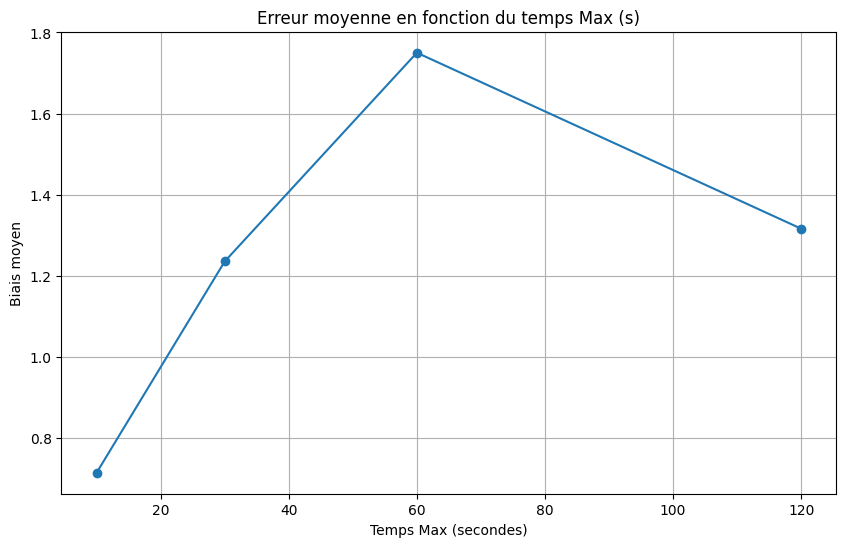

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm , marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

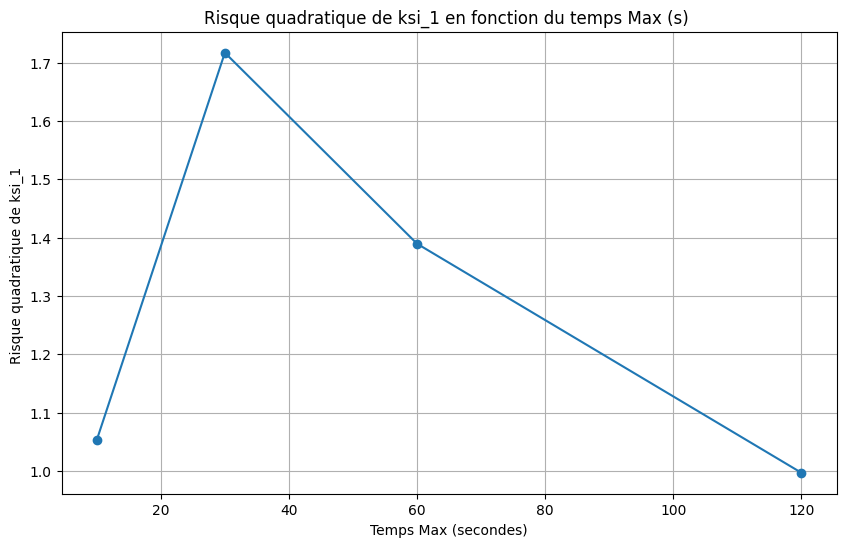

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_0, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_1 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_1 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

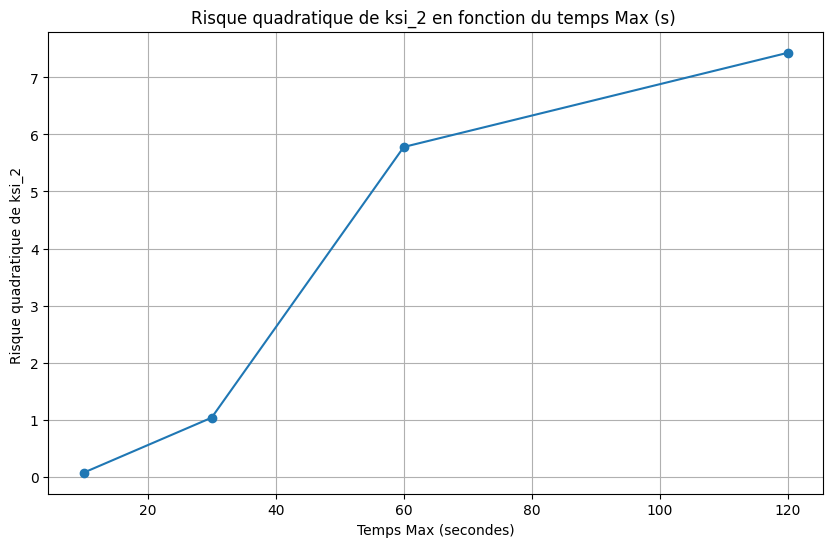

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_1, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_2 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_2 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

In [21]:
temps_max_values = [10, 30, 60, 120]
standard_error_hyper = []
standard_error_hypersigma = []
distance_hyper = []
distance_hypersigm = []
epsilon=[]
erreur_quadratique_0=[]
erreur_quadratique_1=[]

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hypersigma = np.std(hypersigma)
    standard_error_hypersigma.append(std_hypersigma)

    epsilon.append(resultats["Eps_final"]) 

    dist = distance(resultats,hypersigm_real)
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hypersigm.append(dist_hypersigm)
    erreur_quadra_0,erreur_quadra_1= calculate_quadratic_error_individual_components(hypersigma, hypersigm_real)
    erreur_quadratique_0.append(erreur_quadra_0)
    erreur_quadratique_1.append(erreur_quadra_1)


C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]


Temps maximum d'exécution de 10 secondes atteint à la 5ème itération.


C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 30 secondes atteint à la 15ème itération.
Temps maximum d'exécution de 60 secondes atteint à la 29ème itération.


C:\Users\sarah\AppData\Local\Temp\ipykernel_21960\949033940.py:46: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 120 secondes atteint à la 63ème itération.


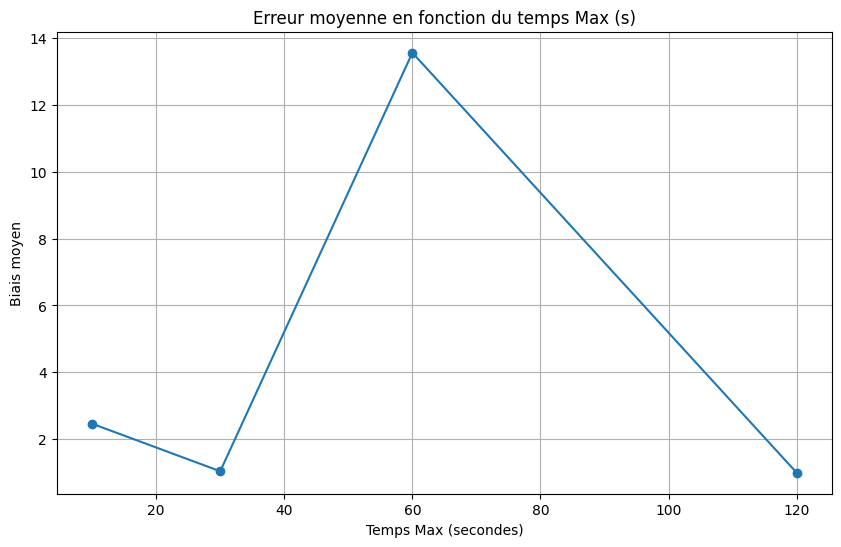

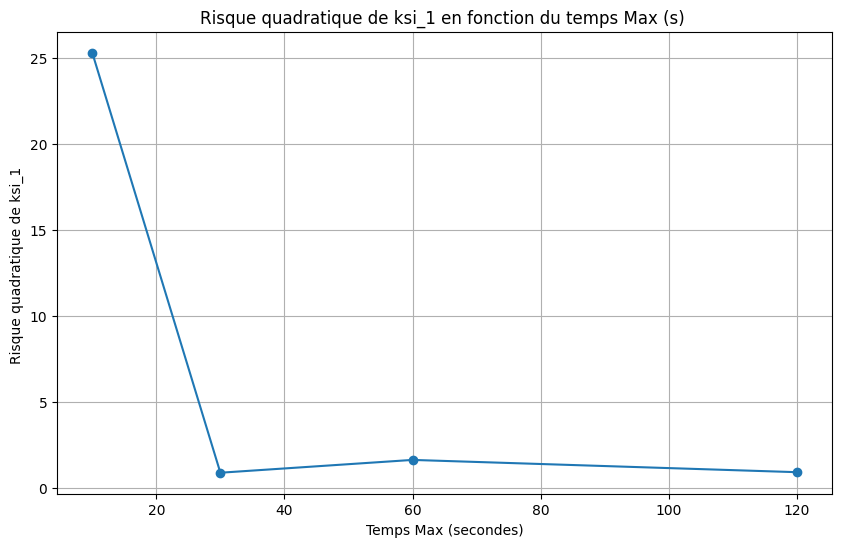

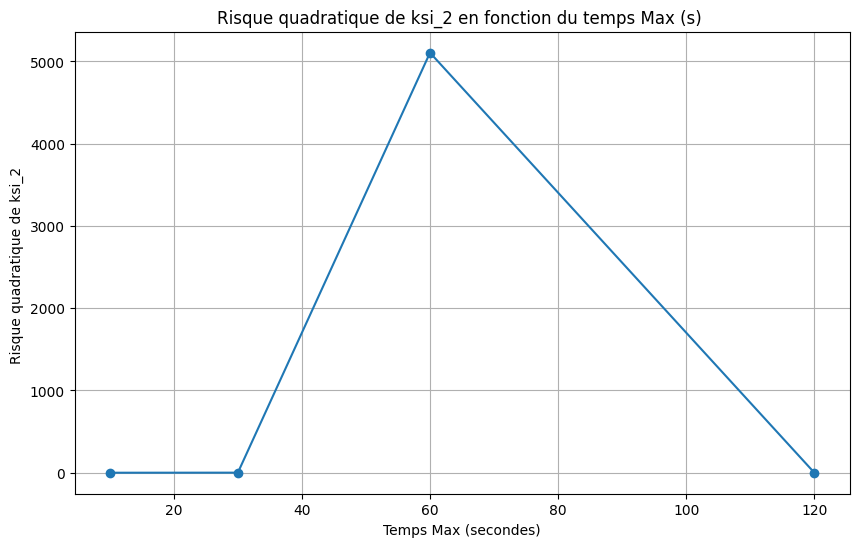

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm , marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_0, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_1 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_1 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_1, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_2 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_2 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

In [ ]:
temps_max_values = [10, 30, 60, 120]
standard_error_hyper = []
standard_error_hypersigma = []
distance_hyper = []
distance_hypersigm = []
epsilon=[]
erreur_quadratique_0=[]
erreur_quadratique_1=[]

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hypersigma = np.std(hypersigma)
    standard_error_hypersigma.append(std_hypersigma)

    epsilon.append(resultats["Eps_final"]) 

    dist = distance(resultats, hyper_real, hypersigm_real)
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hypersigm.append(dist_hypersigm)
    erreur_quadra_0,erreur_quadra_1= calculate_quadratic_error_individual_components(hypersigma, hypersigm_real)
    erreur_quadratique_0.append(erreur_quadra_0)
    erreur_quadratique_1.append(erreur_quadra_1)

ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

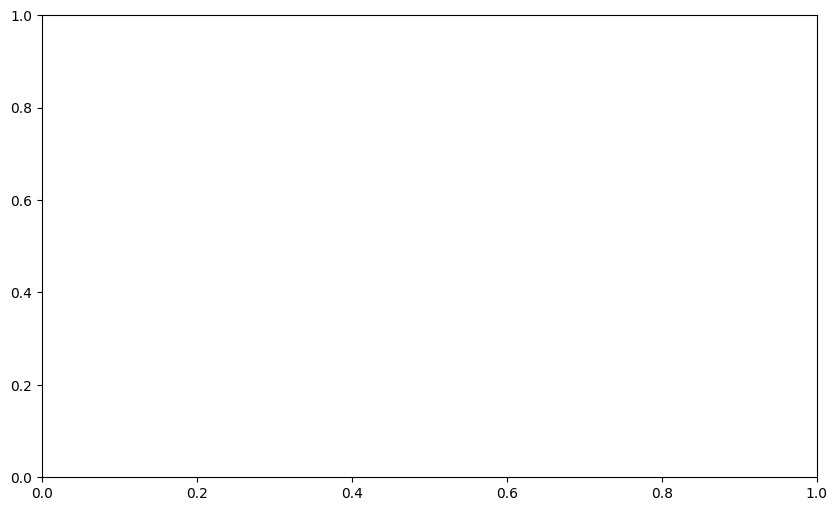

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm , marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_0, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_1 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_1 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_1, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_2 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_2 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()